In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/comp642-project
%mkdir -p v1
%cd v1

Mounted at /content/drive
/content/drive/MyDrive/comp642-project
/content/drive/MyDrive/comp642-project/v1


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow_probability as tfp
import warnings
import time
import gc
import torch
import torch.nn as nn
import lightgbm as lgb
import statsmodels.api as sm
import warnings

from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import _deprecate_positional_args
from torch.utils.data import Dataset, DataLoader, TensorDataset
from joblib import dump, load
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({'font.size': 16})
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyError)


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [ ]:
TRAIN_END_DATE = 424
df = pd.read_csv('../data/train.csv')
train_df = df[df['date_id'] <= TRAIN_END_DATE]
test_df = df[df['date_id'] > TRAIN_END_DATE]
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
del df

utilities

In [ ]:
def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

class CFG:
    BATCH_SIZE = 32
    N_EPOCHS = 500
    LEARNING_RATE = 0.0001
    N_FOLDS = 5
    TARGET_COLS = ['target']
    SEED = 2023
    N_ASSETS = train_df['stock_id'].nunique()
    SCALER = MinMaxScaler()
    WEIGHT_DECAY = 0.4
    DEBUG = True

CFG = CFG()
set_seeds(CFG.SEED)

pre-process

In [ ]:
train_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621975,195,424,540,1755710.13,-1,1.000637,23963918.01,0.999999,0.999999,1.000637,38626.10,1.000743,185519.18,1.000655,2.089739,23374,424_540_195
4621976,196,424,540,325741.25,-1,0.999755,8239249.46,0.999262,0.999755,0.999755,42180.16,1.000002,16034.04,0.999934,2.579689,23374,424_540_196
4621977,197,424,540,572162.23,1,0.999981,9207011.59,1.000203,1.000203,0.999870,40522.50,0.999981,61781.16,0.999914,-2.359748,23374,424_540_197
4621978,198,424,540,0.00,0,1.001219,72541114.32,1.001219,1.001219,1.000953,497503.65,1.001219,630439.20,1.001070,9.089708,23374,424_540_198


In [ ]:
def preprocess(df, mode='train'):
    # print(df.columns)
    df['log_return'] = np.log(df['wap'])
    df.drop(['imbalance_buy_sell_flag', 'far_price', 'near_price'], axis=1, inplace=True)

    for i in range(1, 10):
        df[f'imbalance_size_lag_{i}'] = df.groupby('stock_id')['imbalance_size'].shift(i)
        df[f'reference_price_lag_{i}'] = df.groupby('stock_id')['reference_price'].shift(i)
        df[f'matched_size_lag_{i}'] = df.groupby('stock_id')['matched_size'].shift(i)
        df[f'bid_price_lag_{i}'] = df.groupby('stock_id')['bid_price'].shift(i)
        df[f'ask_price_lag_{i}'] = df.groupby('stock_id')['ask_price'].shift(i)
        df[f'wap_{i}'] = df.groupby('stock_id')['wap'].shift(i)

    df['bid_size_lag_1'] = df.groupby('stock_id')['bid_size'].shift(1)
    df['ask_size_lag_1'] = df.groupby('stock_id')['ask_size'].shift(1)

    df.fillna(0, inplace=True)
    # Standardize
    if mode == 'train':
        # print(df.columns)
        cols_to_norm = df.drop(['stock_id', 'time_id', 'date_id', 'row_id', 'target', 'seconds_in_bucket'], axis=1).columns
        df[cols_to_norm] = CFG.SCALER.fit_transform(df[cols_to_norm])
    elif mode == 'test':
        cols_to_norm = df.drop(['stock_id', 'time_id', 'date_id', 'row_id', 'target', 'seconds_in_bucket'], axis=1).columns
        df[cols_to_norm] = CFG.SCALER.transform(df[cols_to_norm])
    else:
        print('Wrong Mode.')
    return df

train_df = preprocess(train_df)

outout

In [ ]:

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    stacking_mode : bool, default=True
        Whether to provide an additional set to test a stacking classifier or not.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    max_val_group_size : int, default=Inf
        Maximum group size for a single validation set.
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split, if stacking_mode = True and None
        it defaults to max_val_group_size.
    val_group_gap : int, default=None
        Gap between train and validation
    test_group_gap : int, default=None
        Gap between validation and test, if stacking_mode = True and None
        it defaults to val_group_gap.
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_val_group_size=np.inf,
                 max_test_group_size=np.inf,
                 val_group_gap=None,
                 test_group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.max_val_group_size = max_val_group_size
        self.max_test_group_size = max_test_group_size
        self.val_group_gap = val_group_gap
        self.test_group_gap = test_group_gap
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        return self.split_standard(X, y, groups)

    def split_standard(self, X, y=None, groups=None):
        """Generate indices to split data into training and validation set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/validation set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        val : ndarray
            The validation set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_splits = self.n_splits
        group_gap = self.val_group_gap
        max_val_group_size = self.max_val_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_val_size = min(n_groups // n_folds, max_val_group_size)
        group_val_starts = range(n_groups - n_splits * group_val_size,
                                  n_groups, group_val_size)
        for group_val_start in group_val_starts:
            train_array = []
            val_array = []

            group_st = max(0, group_val_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_val_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for val_group_idx in unique_groups[group_val_start:
                                                group_val_start +
                                                group_val_size]:
                val_array_tmp = group_dict[val_group_idx]
                val_array = np.sort(np.unique(
                                              np.concatenate((val_array,
                                                              val_array_tmp)),
                                     axis=None), axis=None)

            val_array  = val_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in val_array]

model

In [ ]:
def global_average_pooling(x):
    return x.mean(dim=(-1))

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.batchnorm1d = nn.BatchNorm1d(200)
        self.conv1d1 = nn.Conv1d(200, 8, 3)
        self.conv1d2 = nn.Conv1d(8, 8, 3)
        self.conv1d3 = nn.Conv1d(8, 16, 3)
        self.conv1d4 = nn.Conv1d(16, 16, 3)
        self.conv1d5 = nn.Conv1d(16, 32, 3)
        self.conv1d6 = nn.Conv1d(32, 32, 3)
        self.conv1d7 = nn.Conv1d(32, 32, 3)

        self.pool1d1 = nn.AvgPool1d(2)
        self.pool1d2 = nn.AvgPool1d(2)

        self.linear1 = nn.Linear(32, 32)
        self.linear2 = nn.Linear(32, 200)

    def forward(self, inputs):
        x = self.batchnorm1d(inputs)
        x = self.conv1d1(x)
        x = self.conv1d2(x)
        x = self.pool1d1(x)

        x = self.conv1d3(x)
        x = self.conv1d4(x)
        x = self.pool1d2(x)

        x = self.conv1d5(x)
        x = self.conv1d6(x)
        x = self.conv1d7(x)

        out = global_average_pooling(x)

        out = self.linear1(out)
        out = nn.ReLU()(out)

        output = self.linear2(out)

        return output

def pad_df(df):
    missing_ids = list(set(np.arange(0, 200)) - set(df.index))
    for id in missing_ids:
        df.loc[id] = 0
    df.sort_index(inplace=True)
    return df

def get_dataset(df):
    X = []
    y = []
    for name, group in df.groupby('time_id'):
        group = group.set_index('stock_id')
        if len(group) < 200:
            group = pad_df(group)
        features = torch.tensor(group.drop(['time_id', 'date_id', 'row_id', 'target'], axis=1).values, dtype=torch.float32)
        labels = group['target'].values
        X.append(features)
        y.append(labels)
    X_ = torch.stack(X)
    y_ = torch.tensor(np.array(y), dtype=torch.float32)
    return TensorDataset(X_, y_)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_val, y_pred):
    all_scores = []
    for i in range(len(y_val)):
        score = mean_absolute_error(y_val[i], y_pred[i])
        all_scores.append(score)
    return np.mean(all_scores)

def train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device):
    losses = AverageMeter()
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        losses.update(loss.item(), labels.size(0))
        loss.backward()
        optimizer.step()
    return losses.avg

def valid_fn(valid_dataloader, model, loss_fn, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    for step, (input_ids, labels) in enumerate(valid_dataloader):
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            outputs = model(input_ids)
            loss = loss_fn(outputs, labels)
        losses.update(loss.item(), batch_size)
        preds.append(outputs.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def train_loop(train, val, fold):
    print(f'----------------- Fold: {fold+1} -----------------')

    train_ds = get_dataset(train)
    val_ds = get_dataset(val)
    _, y_val = val_ds[:]

    train_dataloader = DataLoader(
            train_ds,
            batch_size = CFG.BATCH_SIZE
    )

    val_dataloader = DataLoader(
            val_ds,
            batch_size = CFG.BATCH_SIZE
    )

    model = CNN().to(device)
    optimizer_parameters = [
            {'params': [p for n, p in model.named_parameters()],
             'lr': CFG.LEARNING_RATE, 'weight_decay': CFG.WEIGHT_DECAY},
        ]


    optimizer = torch.optim.AdamW(optimizer_parameters)
    loss_fn = nn.MSELoss()
    min_score = np.inf
    wait = 0
    patience=10

    for epoch in range(CFG.N_EPOCHS):
        avg_loss = train_fn(fold, train_dataloader, model, loss_fn, optimizer, epoch, device)

        avg_val_loss, y_pred = valid_fn(val_dataloader, model, loss_fn, device)

        score = get_score(y_val, y_pred)

        print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f} avg_val_loss: {avg_val_loss:.4f} MAE: {score:.4f}')

        wait += 1
        if round(score, 4) < round(min_score, 4):
            min_score = score
            wait = 0
            torch.save(model.state_dict(), f'model_fold_{fold+1}')
            print(f'﹂ saving model with score: {min_score:.4f}')
        if wait >= patience:
            print(f'Triggering Early Stopping on epoch {epoch+1}')
            return min_score

    gc.collect()

In [ ]:
def train(df):
    Fold = PurgedGroupTimeSeriesSplit(n_splits=CFG.N_FOLDS,
                                      max_train_group_size=10000,
                                      max_val_group_size=200,
                                      val_group_gap=10)
    scores = np.empty([CFG.N_FOLDS])
    groups = df['time_id']
    for fold, (train_index, val_index) in enumerate(Fold.split(df, df[CFG.TARGET_COLS], groups=groups)):
        train = df.iloc[train_index].reset_index(drop=True)
        val = df.iloc[val_index].reset_index(drop=True)
        score = train_loop(train, val, fold)
        scores[fold] = score
    print(f'Average MAE across folds: {np.mean(scores)}')

train(train_df)

----------------- Fold: 1 -----------------
Epoch 1 - avg_train_loss: 85.7150 avg_val_loss: 117.3040 MAE: 7.0932
﹂ saving model with score: 7.0932
Epoch 2 - avg_train_loss: 85.7068 avg_val_loss: 117.3216 MAE: 7.0948
Epoch 3 - avg_train_loss: 85.6993 avg_val_loss: 117.3383 MAE: 7.0960
Epoch 4 - avg_train_loss: 85.6928 avg_val_loss: 117.3559 MAE: 7.0975
Epoch 5 - avg_train_loss: 85.6867 avg_val_loss: 117.3731 MAE: 7.0988
Epoch 6 - avg_train_loss: 85.6807 avg_val_loss: 117.3897 MAE: 7.1000
Epoch 7 - avg_train_loss: 85.6753 avg_val_loss: 117.4077 MAE: 7.1012
Epoch 8 - avg_train_loss: 85.6705 avg_val_loss: 117.4249 MAE: 7.1022
Epoch 9 - avg_train_loss: 85.6662 avg_val_loss: 117.4408 MAE: 7.1032
Epoch 10 - avg_train_loss: 85.6625 avg_val_loss: 117.4552 MAE: 7.1040
Epoch 11 - avg_train_loss: 85.6593 avg_val_loss: 117.4680 MAE: 7.1047
Triggering Early Stopping on epoch 11
----------------- Fold: 2 -----------------
Epoch 1 - avg_train_loss: 85.7168 avg_val_loss: 81.8461 MAE: 6.2986
﹂ saving mo

In [ ]:
def get_models():
    models = []
    for i in range(CFG.N_FOLDS):
        model = CNN()
        model.load_state_dict(torch.load(f'model_fold_{i+1}'))
        model.eval()
        models.append(model)
    return models

def inference(models, y_test):
    preds = []
    for i in range(len(models)):
        print(f'Inferencing model {i+1}')
        pred = models[i](y_test)[0]
        preds.append(pred.detach().numpy())
    return np.mean(preds, axis=0)

In [ ]:
print(len(test_df))

cols_during_training = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id']

assert not [c for c in test_df.columns if c not in cols_during_training]
assert not [c for c in cols_during_training if c not in test_df.columns]

# sort df_tes columns as C
test_df = test_df[cols_during_training]
new_df_processed = preprocess(test_df, mode='test')
new_dataset = get_dataset(new_df_processed)

616000


In [ ]:
def predict_with_models(models, dataset):
    dataloader = DataLoader(dataset, batch_size=len(new_dataset), shuffle=False)
    all_predictions = []
    for model in models:
        model_predictions = []
        for inputs, _ in dataloader:  # No labels in prediction
            model = model.to(device)
            inputs = inputs.to(device)  # Move inputs to the same device as model
            with torch.no_grad():
                outputs = model(inputs)
                model_predictions.append(outputs.cpu().numpy())
        all_predictions.append(np.concatenate(model_predictions, axis=0))
    # Average predictions across models
    avg_predictions = np.mean(all_predictions, axis=0)
    return avg_predictions

models = get_models()
preds = predict_with_models(models, new_dataset)

In [ ]:
preds = preds.flatten()
print(preds[0])
print("MAE", abs(preds - test_df['target']).mean())

# count the number of predictions that were same sign
same_sign = np.sign(preds) == np.sign(test_df['target'])
print("Sign Accuracy", same_sign.sum() / len(preds))

-0.017317517
MAE 5.850025976086137
Sign Accuracy 0.502099025974026


In [ ]:
# make a df from preds and y_test
df = pd.DataFrame({'preds': preds, 'y_test': test_df['target']})
df.to_csv('preds.csv', index=False)

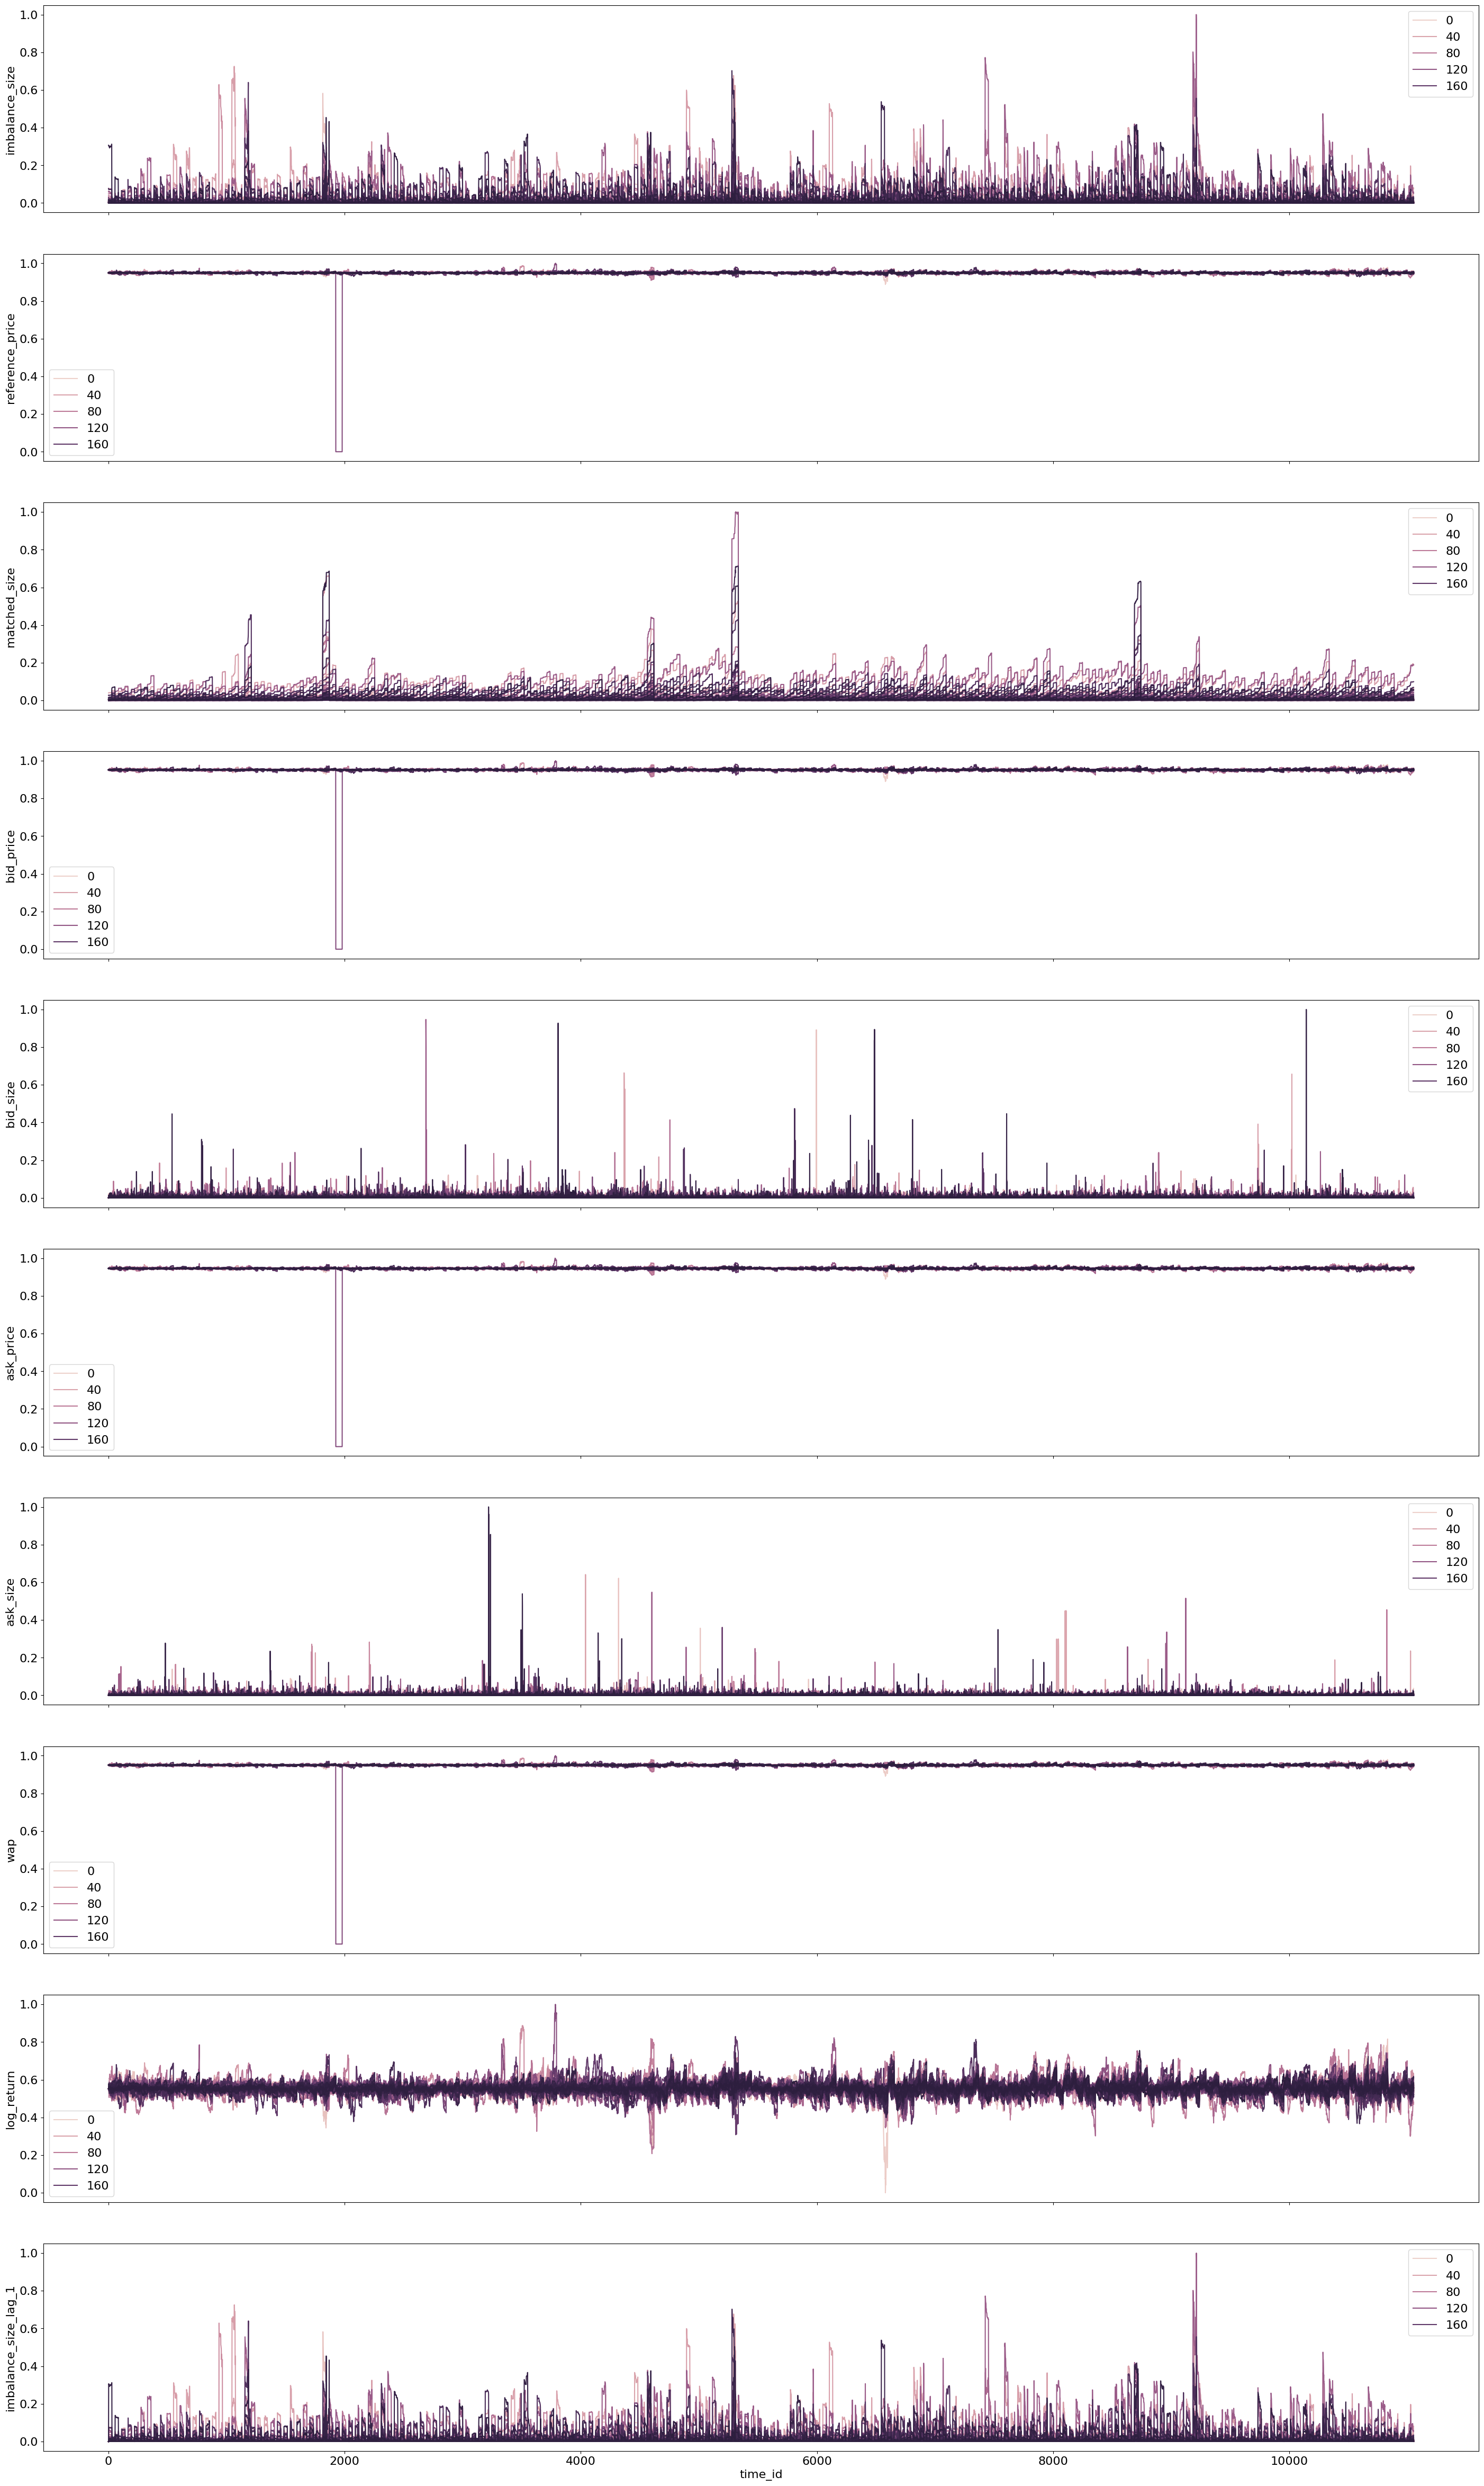

In [ ]:
def plot_hist(df):
    COLS = list(df.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'time_id'], axis=1).columns)
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(35,60))
    for col, ax in zip(COLS, axes.ravel()):
        sns.lineplot(data=df, x='time_id', y=df[col], hue='stock_id', ax=ax)
        ax.legend(loc='best')

plot_hist(train_df)

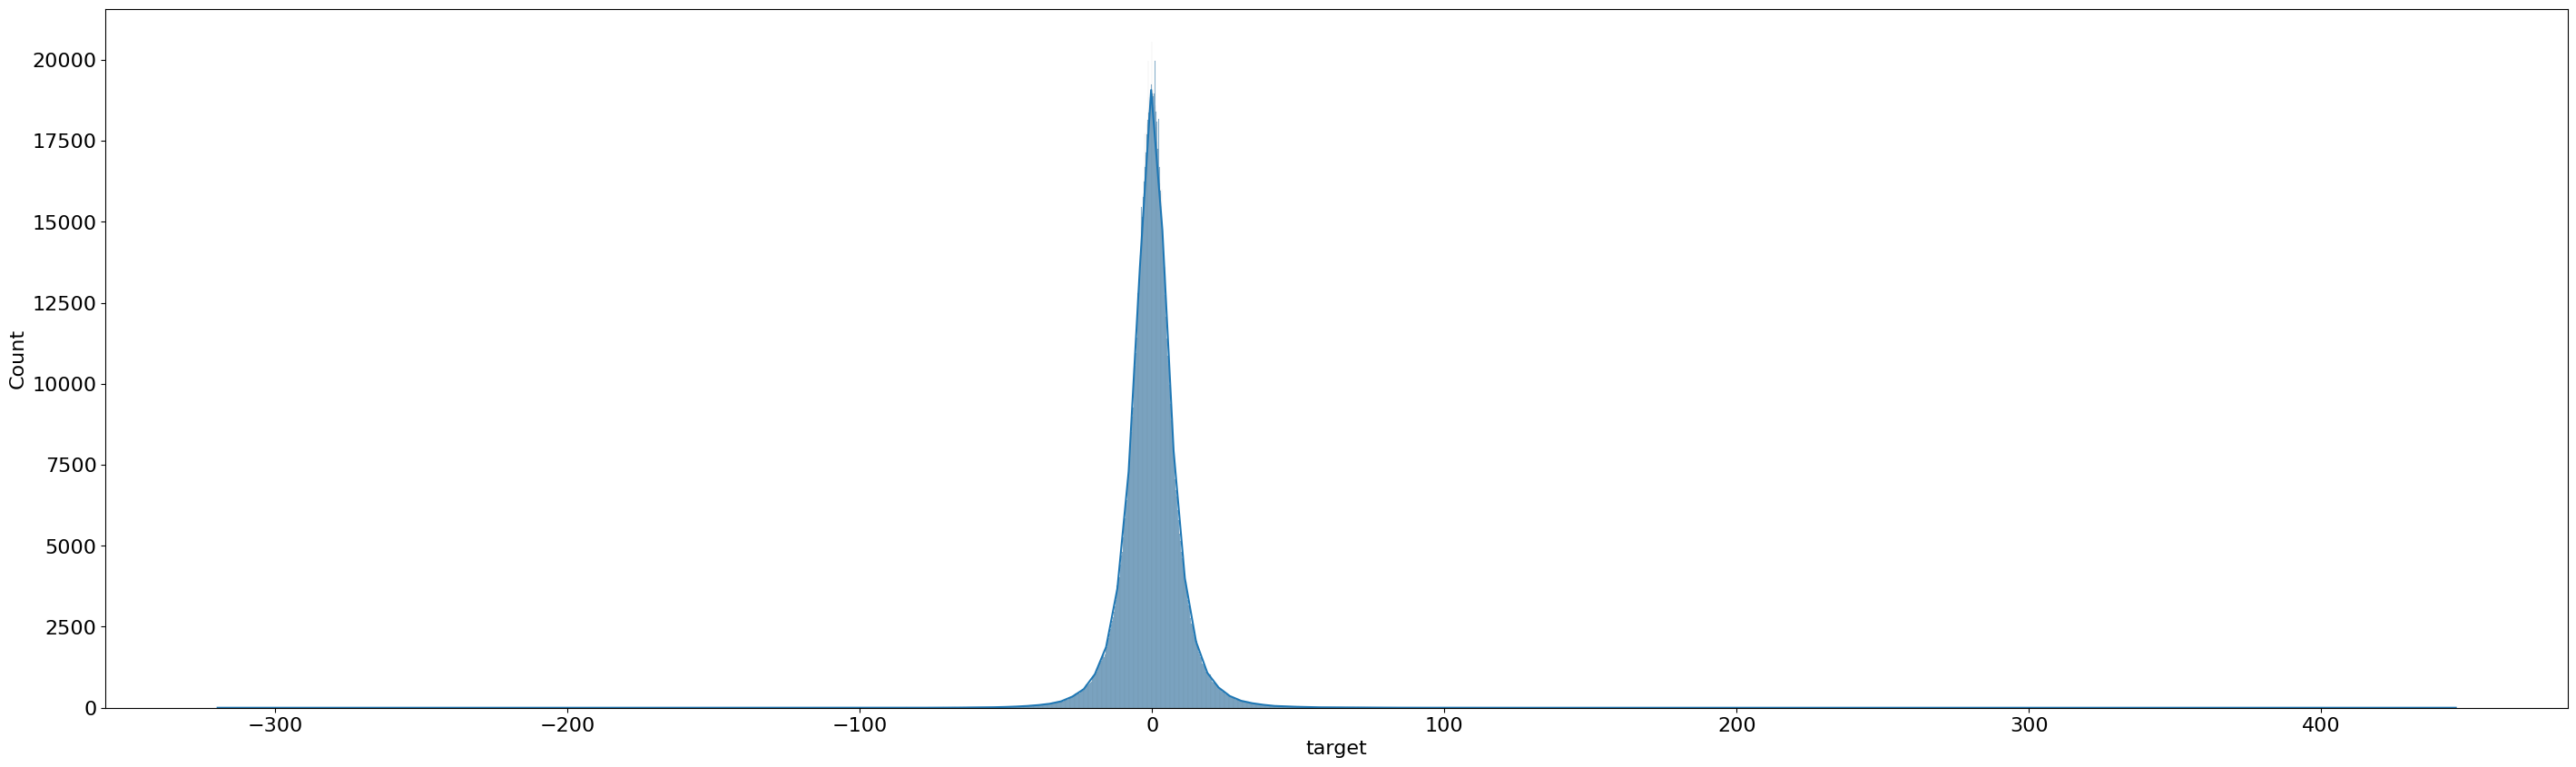

In [ ]:
def plot_target(df):
    plt.figure(figsize=(35, 10))
    sns.histplot(data=df, x='target', kde=True)

plot_target(train_df)

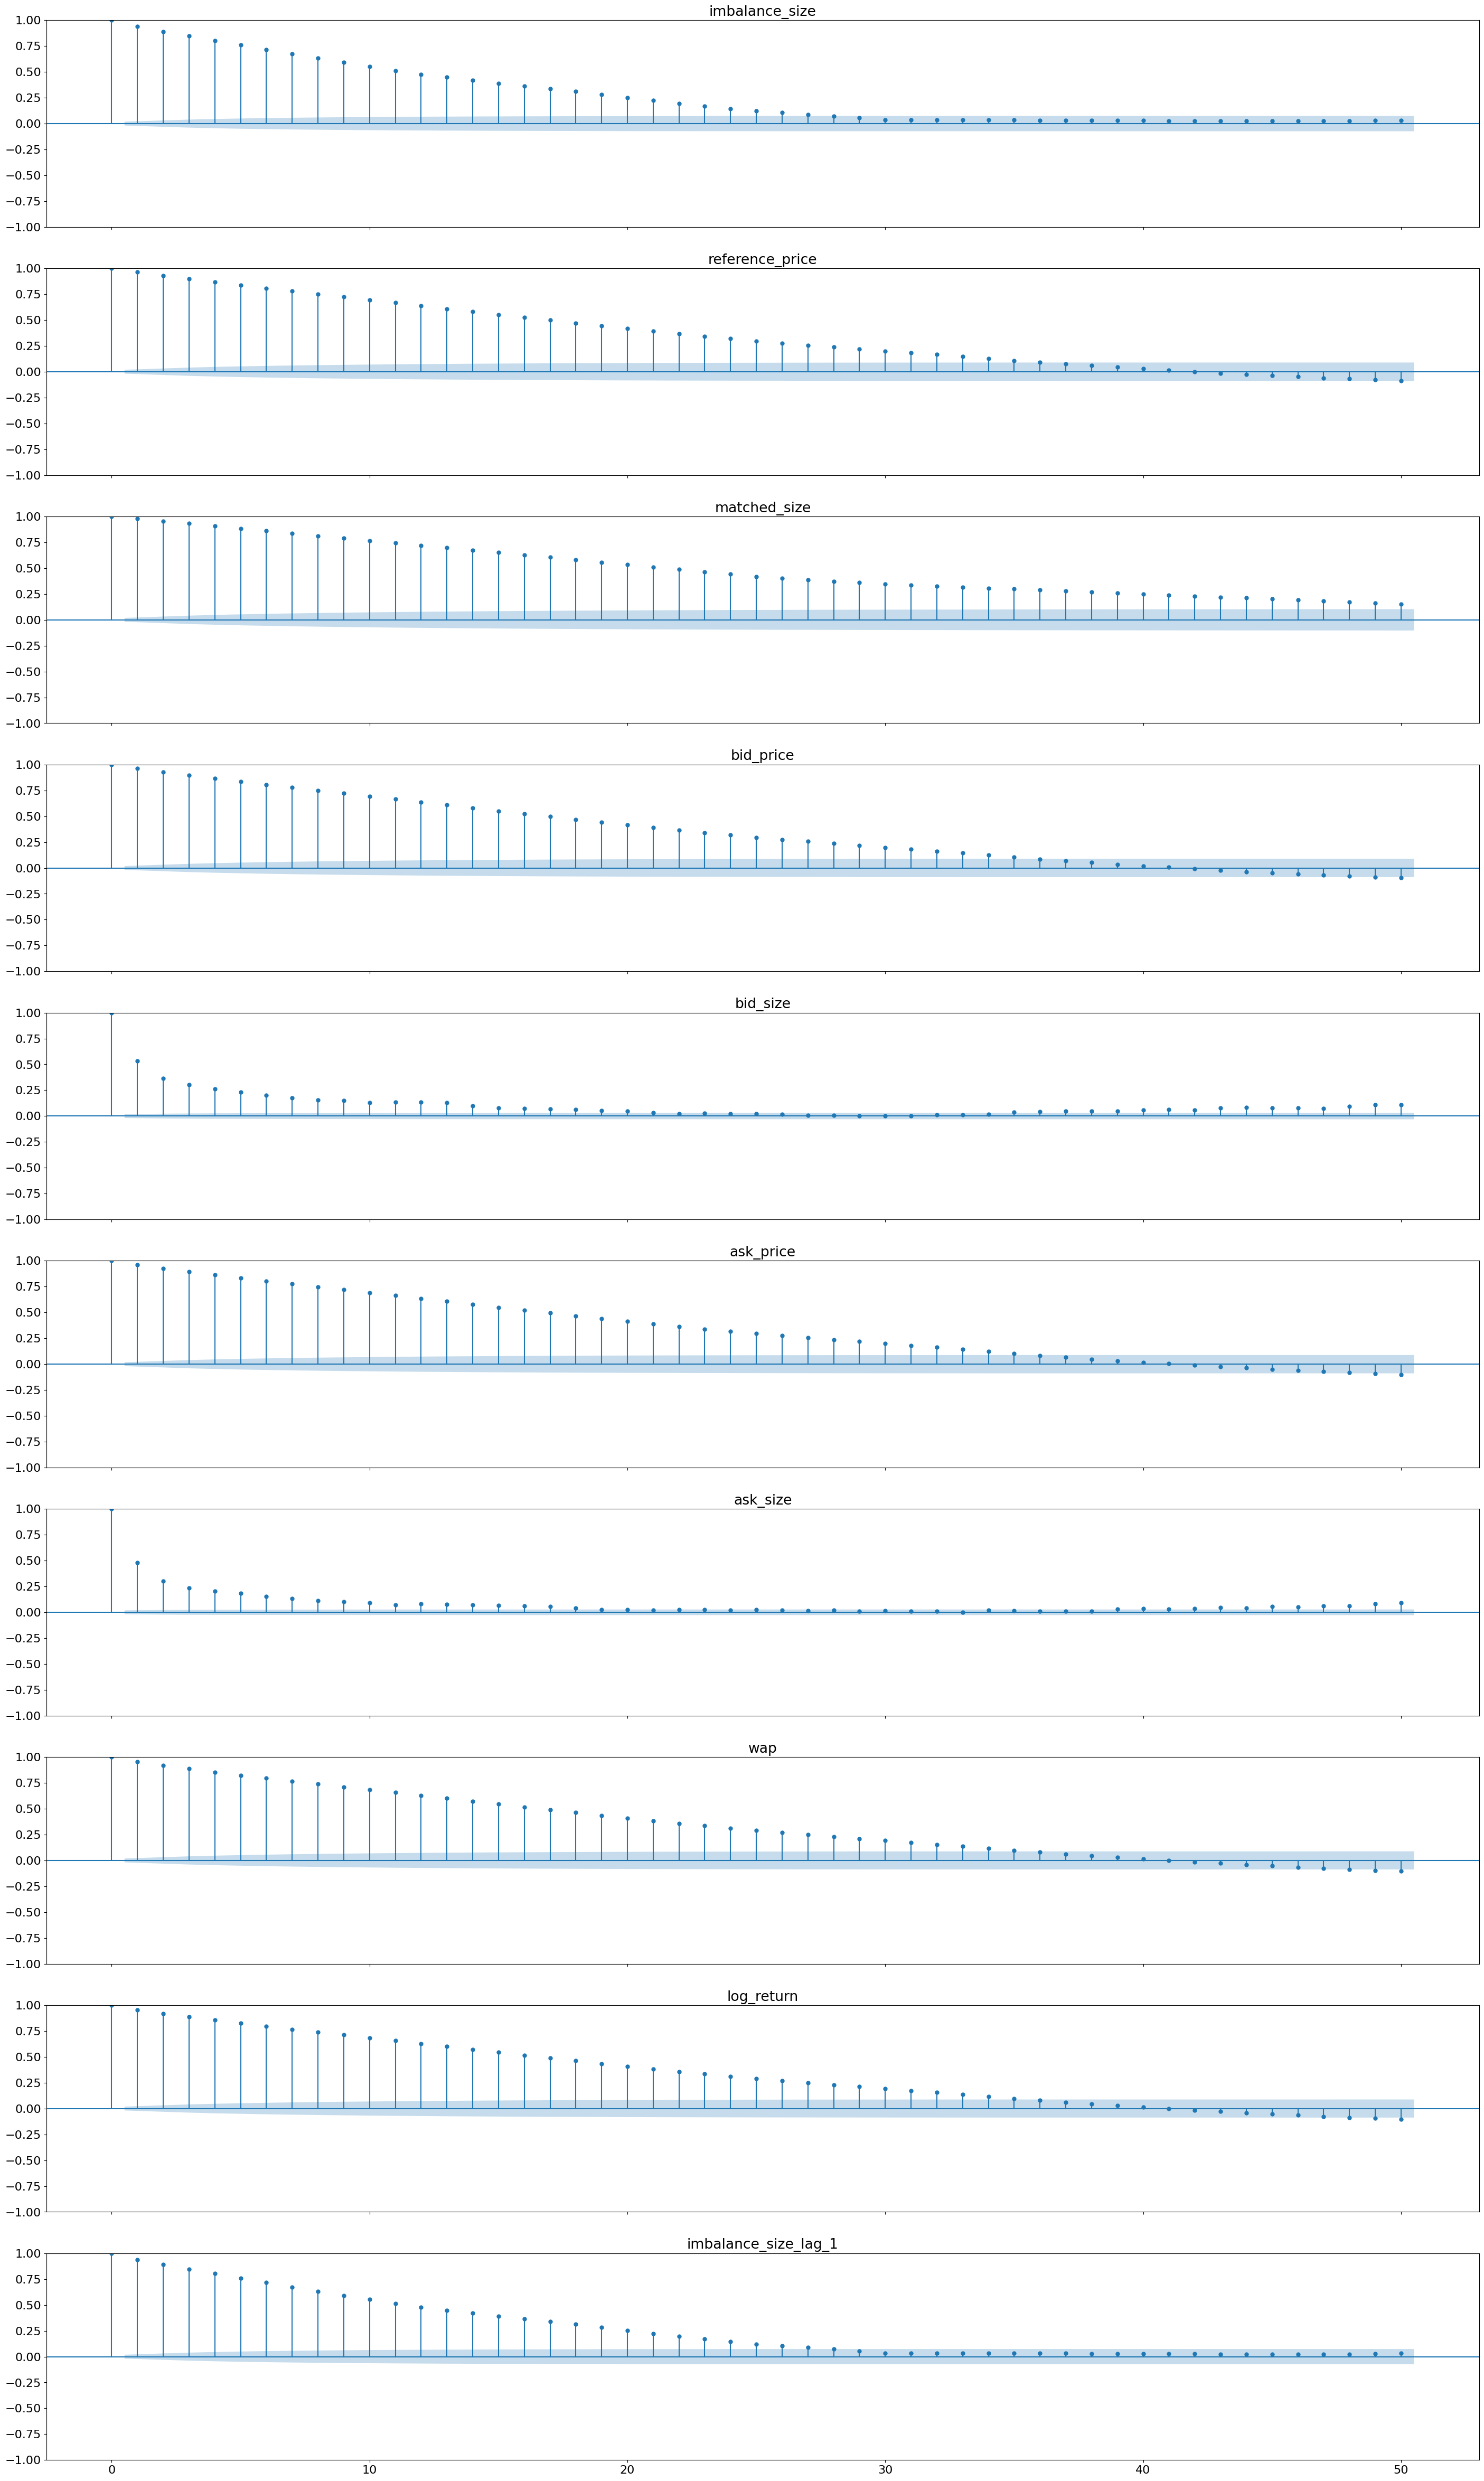

In [ ]:
def plot_auto_corr(df):
    COLS = list(df.drop(['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id', 'time_id'], axis=1).columns)
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(35,60))
    for col, ax in zip(COLS, axes.ravel()):
        stock = df[df['stock_id']==1]
        plot_acf(stock[col][:500000], lags=50, ax=ax)
        ax.set_title(str(col))

plot_auto_corr(train_df)